In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import geopandas as gpd
import seaborn as sns

#Packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from scipy import stats
pd.set_option('display.max_columns', None)

from scipy.stats import skew, kurtosis

import pygris
from shapely.geometry import Polygon

import shapely

In [2]:
df = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/FimaNfipClaims.parquet.gzip")

In [3]:
df_geographic_unique = df[['state', 'reportedZipCode', 'countyCode', 'censusTract', 'censusBlockGroupFips', 'latitude', 'longitude', 'yearOfLoss']].drop_duplicates()

In [4]:
df_geographic_unique = df_geographic_unique.dropna(subset=['censusBlockGroupFips', 'reportedZipCode', 'countyCode'])

In [5]:
df_geographic_unique['reportedZipCode'] = df_geographic_unique['reportedZipCode'].dropna().astype(int).astype(str)
df_geographic_unique['reportedZipCode'] = [zipcode.zfill(5) for zipcode in df_geographic_unique['reportedZipCode']]

df_geographic_unique['censusBlockGroupFips'] = [str(int(float(i))) for i in df_geographic_unique['censusBlockGroupFips']]
df_geographic_unique['censusBlockGroupFips'] = [censusBG.zfill(12) for censusBG in df_geographic_unique['censusBlockGroupFips']]

df_geographic_unique['countyCode'] = [str(int(float(i))) for i in df_geographic_unique['countyCode']]
df_geographic_unique['countyCode'] = [censusBG.zfill(5) for censusBG in df_geographic_unique['countyCode']]

df_geographic_unique['censusTract'] = [str(int(float(i))) for i in df_geographic_unique['censusTract']]
df_geographic_unique['censusTract'] = [censusBG.zfill(11) for censusBG in df_geographic_unique['censusTract']]

In [6]:
# Define bins and labels for yearOfLoss_2000_2021
bins_2000_2021 = [df_geographic_unique['yearOfLoss'].min(), 2010, 2020, df_geographic_unique['yearOfLoss'].max() + 1]
labels_2000_2021 = [2000, 2010, 2020]

df_geographic_unique['yearOfLoss_2000_2021'] = pd.cut(df_geographic_unique['yearOfLoss'], bins=bins_2000_2021, labels=labels_2000_2021, right=False).astype(int)

# Define bins and labels for yearOfLoss_1990_2021
bins_1990_2021 = [df_geographic_unique['yearOfLoss'].min(), 2000, 2010, 2020, df_geographic_unique['yearOfLoss'].max() + 1]
labels_1990_2021 = [1990, 2000, 2010, 2020]

df_geographic_unique['yearOfLoss_1990_2021'] = pd.cut(df_geographic_unique['yearOfLoss'], bins=bins_1990_2021, labels=labels_1990_2021, right=False).astype(int)

df_geographic_unique = df_geographic_unique.drop(columns='yearOfLoss')

In [7]:
df_geographic_unique.head()

,state,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,yearOfLoss_2000_2021,yearOfLoss_1990_2021
0,CA,92056,06073,06073018512,060730185123,33.2,-117.3,2000,1990
1,LA,70131,22071,22071000616,220710006163,29.9,-90.0,2000,2000
2,FL,32566,12113,12113010815,121130108152,30.4,-86.9,2000,1990
3,SC,29902,45013,45013000700,450130007002,32.4,-80.7,2000,1990
4,FL,32940,12009,12009063107,120090631073,28.3,-80.7,2000,1990


## Read shapefiles

In [8]:
states = pygris.states()

state_df = states[['STUSPS', 'NAME', 'geometry']]

Using the default year of 2021


In [9]:
#Checking if all states found in our dataset are in the US Census Bureau TIGER/Line and cartographic boundary shapefiles

unique_states = df_geographic_unique['state'].unique()
state_STUSPS_unique = state_df['STUSPS'].unique()

np.all(np.isin(unique_states, state_STUSPS_unique))

True

In [10]:
# Read the parquet file
df_read = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/lat_long_geometry.parquet.gzip")

# Convert the WKT strings back to geometries
lat_long_df = gpd.GeoDataFrame(df_read, geometry=df_read['geometry'].apply(lambda x: shapely.wkt.loads(x)))

In [11]:
chunk_size = 25000  # adjust based on your system's capabilities
chunks = [x for x in range(0, 400000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/BG_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)

# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
BG_df = pd.concat(gdf_list, ignore_index=True)

BG_df['year'] = BG_df['year'].replace({2012: 2010, 2021: 2020})
BG_df = BG_df.drop_duplicates(subset=['GEOID', 'year'])

In [12]:
chunk_size = 25000  # adjust based on your system's capabilities
chunks = [x for x in range(0, 100000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/zipcode_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)
    
# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
zipcode_df = pd.concat(gdf_list, ignore_index=True)

zipcode_df['year'] = zipcode_df['year'].replace({2012: 2010, 2021: 2020})
zipcode_df = zipcode_df.drop_duplicates(subset=['ZIPcode', 'year'])

In [13]:
# Read the parquet file
df_read = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/County_geometry.parquet.gzip")

# Convert the WKT strings back to geometries
County_df = gpd.GeoDataFrame(df_read, geometry=df_read['geometry'].apply(lambda x: shapely.wkt.loads(x)))

County_df['year'] = County_df['year'].replace({2012: 2010, 2021: 2020})
County_df = County_df.drop_duplicates(subset=['CountyID', 'year'])

In [14]:
# Read the parquet file
df_read = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/Tract_geometry.parquet.gzip")

# Convert the WKT strings back to geometries
Tract_df = gpd.GeoDataFrame(df_read, geometry=df_read['geometry'].apply(lambda x: shapely.wkt.loads(x)))
Tract_df['year'] = Tract_df['year'].replace({2012: 2010, 2021: 2020})
Tract_df = Tract_df.drop_duplicates(subset=['censusTractID', 'year'])

## Create centroid

In [15]:
# 1. Calculate centroids

lat_long_df.loc[:, 'centroid_lat_long'] = lat_long_df['geometry'].centroid

BG_df.loc[:, 'centroid_BG'] = BG_df['geometry'].centroid

zipcode_df.loc[:, 'centroid_zipcode'] = zipcode_df['geometry'].centroid

County_df.loc[:, 'centroid_county'] = County_df['geometry'].centroid

Tract_df.loc[:, 'centroid_tract'] = Tract_df['geometry'].centroid

##  Spatial join: for each centroid, determine which state it intersects (either falls within or on the boundary)

In [16]:
# 2. Spatial join: for each centroid, determine which state it intersects (either falls within or on the boundary)

lat_long_df.set_geometry('centroid_lat_long', inplace=True)
lat_long_df.crs = "EPSG:4269"

lat_long_df = lat_long_df.to_crs(state_df.crs)

joined = gpd.sjoin(lat_long_df, state_df, predicate='within')

# 3. Create the 'corrected_state' column using the 'STUSPS' column from the join operation
lat_long_df['corrected_state_lat_long'] = joined['STUSPS']
lat_long_df['corrected_state_lat_long'] = lat_long_df['corrected_state_lat_long'].fillna('Not_within_any_state')

#-------------

BG_df.set_geometry('centroid_BG', inplace=True)
BG_df.crs = "EPSG:4269"

BG_df = BG_df.to_crs(state_df.crs)

joined = gpd.sjoin(BG_df.set_geometry('centroid_BG'), state_df, predicate='within')

BG_df['corrected_state_BG'] = joined['STUSPS']
BG_df['corrected_state_BG'] = BG_df['corrected_state_BG'].fillna('Not_within_any_state')

#-------------

zipcode_df.set_geometry('centroid_zipcode', inplace=True)
zipcode_df.crs = "EPSG:4269"

zipcode_df = zipcode_df.to_crs(state_df.crs)

joined = gpd.sjoin(zipcode_df.set_geometry('centroid_zipcode'), state_df, predicate='within')

zipcode_df['corrected_state_zipcode'] = joined['STUSPS']
zipcode_df['corrected_state_zipcode'] = zipcode_df['corrected_state_zipcode'].fillna('Not_within_any_state')

#-------------

County_df.set_geometry('centroid_county', inplace=True)
County_df.crs = "EPSG:4269"

County_df = County_df.to_crs(state_df.crs)

joined = gpd.sjoin(County_df.set_geometry('centroid_county'), state_df, predicate='within')

County_df['corrected_state_county'] = joined['STUSPS']
County_df['corrected_state_county'] = County_df['corrected_state_county'].fillna('Not_within_any_state')

#-------------

Tract_df.set_geometry('centroid_tract', inplace=True)
Tract_df.crs = "EPSG:4269"

Tract_df = Tract_df.to_crs(state_df.crs)

joined = gpd.sjoin(Tract_df.set_geometry('centroid_tract'), state_df, predicate='within')

Tract_df['corrected_state_tract'] = joined['STUSPS']
Tract_df['corrected_state_tract'] = Tract_df['corrected_state_tract'].fillna('Not_within_any_state')

## Combining with the original dataframe

In [17]:
# Setting the multi-index on lat_long_df
lat_long_df.set_index(['latitude', 'longitude'], inplace=True)

# Mapping the values
df_geographic_unique['corrected_state_lat_long'] = df_geographic_unique.set_index(['latitude', 'longitude']).index.map(lat_long_df['corrected_state_lat_long'])

# Resetting the index of lat_long_df (optional, but good practice)
lat_long_df.reset_index(inplace=True)

In [18]:
# Initial mapping with multi-index
BG_df.set_index(['GEOID', 'year'], inplace=True)
df_geographic_unique['corrected_state_BG'] = df_geographic_unique.set_index(['censusBlockGroupFips', 'yearOfLoss_1990_2021']).index.map(BG_df['corrected_state_BG'])

# Find rows with NaN values in 'corrected_state_BG'
na_rows = df_geographic_unique['corrected_state_BG'].isna()

# Reset index of BG_df
df_single_index = BG_df.reset_index()

# Sort by 'year' in descending order
df_single_index = df_single_index.sort_values(by='year', ascending=False)

# Drop duplicates based on the 'GEOID' column. Keep the first occurrence.
df_single_index = df_single_index.drop_duplicates(subset='GEOID', keep='first')

# Map these rows using only the 'GEOID'
df_geographic_unique.loc[na_rows, 'corrected_state_BG'] = df_geographic_unique.loc[na_rows, 'censusBlockGroupFips'].map(df_single_index.set_index('GEOID')['corrected_state_BG'])

# Resetting the index of BG_df (return to multi-index)
BG_df.reset_index(inplace=True)

In [19]:
# Initial mapping with multi-index
zipcode_df.set_index(['ZIPcode', 'year'], inplace=True)
df_geographic_unique['corrected_state_zipcode'] = df_geographic_unique.set_index(['reportedZipCode', 'yearOfLoss_2000_2021']).index.map(zipcode_df['corrected_state_zipcode'])

# Find rows with NaN values in 'corrected_state'
na_rows = df_geographic_unique['corrected_state_zipcode'].isna()

# Reset index
df_single_index = zipcode_df.reset_index()

# Sort by 'year' in descending order
df_single_index = df_single_index.sort_values(by='year', ascending=False)

# Drop duplicates based on the 'ZIPcode' column. Keep the first occurrence.
df_single_index = df_single_index.drop_duplicates(subset='ZIPcode', keep='first')

# Map these rows using only the 'ZIPcode'
df_geographic_unique.loc[na_rows, 'corrected_state_zipcode'] = df_geographic_unique.loc[na_rows, 'reportedZipCode'].map(df_single_index.set_index('ZIPcode')['corrected_state_zipcode'])

# Resetting the index (return to multi-index)
zipcode_df.reset_index(inplace=True)

In [20]:
# Initial mapping with multi-index
County_df.set_index(['CountyID', 'year'], inplace=True)
df_geographic_unique['corrected_state_county'] = df_geographic_unique.set_index(['countyCode', 'yearOfLoss_1990_2021']).index.map(County_df['corrected_state_county'])

# Find rows with NaN values in 'corrected_state'
na_rows = df_geographic_unique['corrected_state_county'].isna()

# Reset index
df_single_index = County_df.reset_index()

# Sort by 'year' in descending order
df_single_index = df_single_index.sort_values(by='year', ascending=False)

# Drop duplicates based on the 'CountyID' column. Keep the first occurrence.
df_single_index = df_single_index.drop_duplicates(subset='CountyID', keep='first')

# Map these rows using only the 'CountyID'
df_geographic_unique.loc[na_rows, 'corrected_state_county'] = df_geographic_unique.loc[na_rows, 'countyCode'].map(df_single_index.set_index('CountyID')['corrected_state_county'])

# Resetting the index (return to multi-index)
County_df.reset_index(inplace=True)

In [21]:
# Initial mapping with multi-index
Tract_df.set_index(['censusTractID', 'year'], inplace=True)
df_geographic_unique['corrected_state_tract'] = df_geographic_unique.set_index(['censusTract', 'yearOfLoss_2000_2021']).index.map(Tract_df['corrected_state_tract'])

# Find rows with NaN values in 'corrected_state'
na_rows = df_geographic_unique['corrected_state_tract'].isna()

# Reset index
df_single_index = Tract_df.reset_index()

# Sort by 'year' in descending order
df_single_index = df_single_index.sort_values(by='year', ascending=False)

# Drop duplicates based on the 'CountyID' column. Keep the first occurrence.
df_single_index = df_single_index.drop_duplicates(subset='censusTractID', keep='first')

# Map these rows using only the 'CountyID'
df_geographic_unique.loc[na_rows, 'corrected_state_tract'] = df_geographic_unique.loc[na_rows, 'censusTract'].map(df_single_index.set_index('censusTractID')['corrected_state_tract'])

# Resetting the index (return to multi-index)
Tract_df.reset_index(inplace=True)

In [22]:
df_geographic_unique

,state,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,yearOfLoss_2000_2021,yearOfLoss_1990_2021,corrected_state_lat_long,corrected_state_BG,corrected_state_zipcode,corrected_state_county,corrected_state_tract
0,CA,92056,06073,06073018512,060730185123,33.2,-117.3,2000,1990,CA,CA,CA,CA,CA
1,LA,70131,22071,22071000616,220710006163,29.9,-90.0,2000,2000,LA,LA,LA,LA,LA
2,FL,32566,12113,12113010815,121130108152,30.4,-86.9,2000,1990,FL,FL,FL,FL,FL
3,SC,29902,45013,45013000700,450130007002,32.4,-80.7,2000,1990,SC,SC,SC,SC,SC
4,FL,32940,12009,12009063107,120090631073,28.3,-80.7,2000,1990,FL,FL,FL,FL,FL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584234,MI,49306,26081,26081011001,260810110013,43.1,-85.6,2020,2020,MI,MI,MI,MI,MI
2584235,MI,49073,26015,26015010100,260150101004,42.6,-85.2,2020,2020,MI,MI,MI,MI,MI
2584236,ND,58801,38105,38105953500,381059535001,48.4,-103.7,2020,2020,ND,ND,ND,ND,ND
2584238,TX,75211,48113,48113021200,481130212001,32.7,-96.9,2020,2020,TX,TX,TX,TX,TX


## Finding Mismatches and tagging those

In [23]:
df_copy = df.copy()

In [24]:
df_copy = df_copy.dropna(subset=['censusBlockGroupFips', 'reportedZipCode', 'countyCode'])

In [25]:
df_copy['reportedZipCode'] = df_copy['reportedZipCode'].dropna().astype(int).astype(str)
df_copy['reportedZipCode'] = [zipcode.zfill(5) for zipcode in df_copy['reportedZipCode']]

df_copy['censusBlockGroupFips'] = [str(int(float(i))) for i in df_copy['censusBlockGroupFips']]
df_copy['censusBlockGroupFips'] = [censusBG.zfill(12) for censusBG in df_copy['censusBlockGroupFips']]

df_copy['countyCode'] = [str(int(float(i))) for i in df_copy['countyCode']]
df_copy['countyCode'] = [censusBG.zfill(5) for censusBG in df_copy['countyCode']]

df_copy['censusTract'] = [str(int(float(i))) for i in df_copy['censusTract']]
df_copy['censusTract'] = [censusBG.zfill(11) for censusBG in df_copy['censusTract']]

#### LAT LONG

In [26]:
# Filter out rows where 'state' is not equal to 'corrected_state'
mismatched_df_latlong = df_geographic_unique[df_geographic_unique['state'] != df_geographic_unique['corrected_state_lat_long']]

In [27]:
mismatched_df_latlong

,state,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,yearOfLoss_2000_2021,yearOfLoss_1990_2021,corrected_state_lat_long,corrected_state_BG,corrected_state_zipcode,corrected_state_county,corrected_state_tract
7,HI,96792,15003,15003009703,150030097031,21.4,-158.2,2000,1990,Not_within_any_state,Not_within_any_state,HI,Not_within_any_state,HI
21,SC,29577,45051,45051050500,450510505002,33.7,-78.8,2000,1990,Not_within_any_state,SC,SC,SC,SC
26,FL,32507,12033,12033002603,120330026031,30.3,-87.4,2000,1990,Not_within_any_state,FL,FL,FL,FL
46,FL,32507,12033,12033002603,120330026032,30.3,-87.4,2000,2000,Not_within_any_state,FL,FL,FL,FL
50,FL,32931,12009,12009068300,120090683002,28.3,-80.6,2000,1990,Not_within_any_state,FL,FL,FL,Not_within_any_state
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584136,WA,98332,53053,53053072504,530530725041,47.3,-122.7,2020,2020,Not_within_any_state,WA,WA,WA,WA
2584187,GA,31833,13285,13285961000,132859610002,32.9,-85.2,2020,2020,AL,GA,GA,GA,GA
2584200,NC,27954,37055,37055970602,370559706021,35.9,-75.7,2020,2020,Not_within_any_state,NC,NC,Not_within_any_state,NC
2584203,FL,33190,12086,12086010612,120860106121,25.6,-80.3,2020,2020,Not_within_any_state,FL,FL,FL,FL


In [28]:
list_df_lat_long = list(mismatched_df_latlong[['latitude', 'longitude']].drop_duplicates().itertuples(index=False, name=None))

In [29]:
# Filter df_copy based on the list of tuples and get the number of rows
df_copy[df_copy.set_index(['latitude', 'longitude']).index.isin(list_df_lat_long)].shape[0]

399288

#### BG

In [30]:
# Filter out rows where 'state' is not equal to 'corrected_state'
mismatched_df_BG= df_geographic_unique[df_geographic_unique['state'] != df_geographic_unique['corrected_state_BG']]

In [31]:
list_df_BG = mismatched_df_BG['censusBlockGroupFips'].drop_duplicates().to_list()

In [32]:
df_copy[df_copy['censusBlockGroupFips'].isin(list_df_BG)].shape[0]

155976

#### Zipcode

In [33]:
# Filter out rows where 'state' is not equal to 'corrected_state'
mismatched_df_ZipCode= df_geographic_unique[df_geographic_unique['state'] != df_geographic_unique['corrected_state_zipcode']]

In [34]:
list_df_ZipCode = mismatched_df_ZipCode['reportedZipCode'].drop_duplicates().to_list()

In [35]:
df_copy[df_copy['reportedZipCode'].isin(list_df_ZipCode)].shape[0]

106296

#### County

In [36]:
# Filter out rows where 'state' is not equal to 'corrected_state'
mismatched_df_County= df_geographic_unique[df_geographic_unique['state'] != df_geographic_unique['corrected_state_county']]

In [37]:
list_df_County = mismatched_df_County['countyCode'].drop_duplicates().to_list()

In [38]:
df_copy[df_copy['countyCode'].isin(list_df_County)].shape[0]

161952

#### Tracts

In [39]:
# Filter out rows where 'state' is not equal to 'corrected_state'
mismatched_df_Tract= df_geographic_unique[df_geographic_unique['state'] != df_geographic_unique['corrected_state_tract']]

In [40]:
list_df_Tract = mismatched_df_Tract['censusTract'].drop_duplicates().to_list()

In [41]:
df_copy[df_copy['censusTract'].isin(list_df_Tract)].shape[0]

173363

## Geometry for NC

In [45]:
lat_long_df.rename(columns={'geometry_latlong': 'geometry_lat_long'}, inplace=True)

In [47]:
# Setting the multi-index on lat_long_df
lat_long_df.set_index(['latitude', 'longitude'], inplace=True)

# Mapping the values
df_geographic_unique['geometry_lat_long'] = df_geographic_unique.set_index(['latitude', 'longitude']).index.map(lat_long_df['geometry_lat_long'])

# Resetting the index of lat_long_df (optional, but good practice)
lat_long_df.reset_index(inplace=True)

In [49]:
BG_df.rename(columns={'geometry': 'geometry_BG'}, inplace=True)

In [50]:
# Initial mapping with multi-index
BG_df.set_index(['GEOID', 'year'], inplace=True)
df_geographic_unique['geometry_BG'] = df_geographic_unique.set_index(['censusBlockGroupFips', 'yearOfLoss_1990_2021']).index.map(BG_df['geometry_BG'])

# Find rows with NaN values in 'corrected_state_BG'
na_rows = df_geographic_unique['geometry_BG'].isna()

# Reset index of BG_df
df_single_index = BG_df.reset_index()

# Sort by 'year' in descending order
df_single_index = df_single_index.sort_values(by='year', ascending=False)

# Drop duplicates based on the 'GEOID' column. Keep the first occurrence.
df_single_index = df_single_index.drop_duplicates(subset='GEOID', keep='first')

# Map these rows using only the 'GEOID'
df_geographic_unique.loc[na_rows, 'geometry_BG'] = df_geographic_unique.loc[na_rows, 'censusBlockGroupFips'].map(df_single_index.set_index('GEOID')['geometry_BG'])

# Resetting the index of BG_df (return to multi-index)
BG_df.reset_index(inplace=True)

In [52]:
import geopandas as gpd
from shapely.geometry import Polygon
from itertools import product
import warnings
warnings.filterwarnings("ignore")

In [53]:
visualize_NC_1 = df_geographic_unique[(df_geographic_unique['state'] == 'NC')]
visualize_NC_1 = visualize_NC[['state', 'censusBlockGroupFips', 'latitude', 'longitude', 'yearOfLoss_1990_2021', 'geometry_lat_long', 'geometry_BG']]

In [58]:
visualize_NC_1.head()

,state,censusBlockGroupFips,latitude,longitude,yearOfLoss_1990_2021,geometry_lat_long,geometry_BG
25,NC,370319706051,34.7,-76.8,1990,"POLYGON ((-76.85000 34.65000, -76.75000 34.650...","POLYGON ((-76.80839 34.73407, -76.80643 34.734..."
31,NC,370119302003,36.0,-81.9,2000,"POLYGON ((-81.95000 35.95000, -81.85000 35.950...","POLYGON ((-81.92090 36.06335, -81.92060 36.063..."
90,NC,370559705022,35.3,-75.5,2000,"POLYGON ((-75.55000 35.25000, -75.45000 35.250...","POLYGON ((-75.75293 35.19666, -75.75154 35.196..."
92,NC,371290118003,34.2,-77.8,1990,"POLYGON ((-77.85000 34.15000, -77.75000 34.150...","POLYGON ((-77.81240 34.21731, -77.79851 34.209..."
94,NC,371290118003,34.2,-77.8,1990,"POLYGON ((-77.85000 34.15000, -77.75000 34.150...","POLYGON ((-77.81240 34.21731, -77.79851 34.209..."


In [59]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df = gpd.GeoDataFrame(columns=['geographic_unit_id', 'censusBlockGroupFips', 'latitude', 'longitude', 'geometry', 'year', 'state'])

# Iterate through each row in BG_df_1990 and each row in lat_long_df to find intersections
for idx_unit, row_unit in visualize_NC_1.iterrows():
    year = row_unit['yearOfLoss_1990_2021']
    bg_id = row_unit['censusBlockGroupFips']
    bg_geometry = row_unit['geometry_BG']
    state = row_unit['state']
    lat_long_geometry = row_unit['geometry_lat_long']
    lat = row_unit['latitude']
    long = row_unit['longitude']
    
    # Compute intersection geometry

    intersection_geometry = bg_geometry.intersection(lat_long_geometry)

    # Check if the intersection result is valid
    if not intersection_geometry.is_empty:
        # Create a unique ID for the intersection using the year and indices
        geographic_unit_id = f"{year}_{bg_id}_{int(abs(lat) * 10)}_{int(abs(long) * 10)}"

        # Append intersection information to a list
        new_unit_df = pd.concat([new_unit_df, pd.DataFrame({
            'geographic_unit_id': [geographic_unit_id],
            'censusBlockGroupFips': [bg_id],
            'latitude': [lat],
            'longitude': [long],
            'geometry': [intersection_geometry],
            'year': [year],
            'state': [state]
        })], ignore_index=True)

Average Area: 22.222149189024975 square kilometers


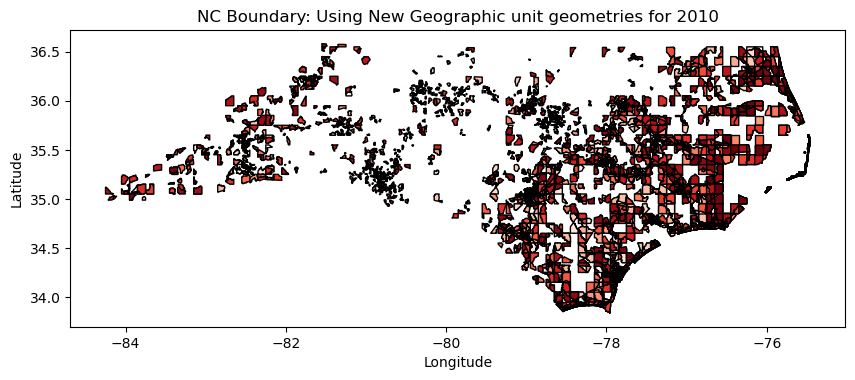

In [74]:
visualize_NC = new_unit_df[(new_unit_df['state'] == 'NC') & (new_unit_df['year'] == 2010)]

# centroids = visualize_NC.geometry.centroid

# # Filter the rows where the y-coordinate (latitude) of the centroid is greater than 42
# visualize_NC = visualize_NC[centroids.y < 37]
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(visualize_NC, geometry='geometry')

# Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
gdf.crs = "EPSG:4326"

# Project the GeoDataFrame to a suitable CRS (using Web Mercator here for demonstration)
gdf_projected = gdf.to_crs(epsg=3857)

# Compute the average area in square meters
average_area_m2 = gdf_projected.geometry.area.mean()
# Convert the area from square meters to square kilometers
average_area_km2 = average_area_m2 / 1e6
print(f"Average Area: {average_area_km2} square kilometers")

# Plot using the 'viridis' colormap
gdf.plot(edgecolor="black", cmap='Reds', figsize=(10, 10))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NC Boundary: Using New Geographic unit geometries for 2010')

plt.show()